Loading EEG data...
Using PCA: Reduced from 320 to 20 features
Explained variance: 98.94%

Training and evaluating models...

Linear Regression:
  Accuracy: 0.1250 ± 0.1581
  Precision: 0.1500 ± 0.2000
  Runtime: 0.2073 seconds

SVM (Linear):
  Accuracy: 0.2500 ± 0.1118
  Precision: 0.2200 ± 0.1222
  Runtime: 0.1207 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


SVM (RBF):
  Accuracy: 0.4250 ± 0.0612
  Precision: 0.3090 ± 0.1107
  Runtime: 0.1088 seconds

SVM (Poly):
  Accuracy: 0.4750 ± 0.0500
  Precision: 0.2929 ± 0.1045
  Runtime: 0.0482 seconds

KNN (k=3):
  Accuracy: 0.2250 ± 0.1458
  Precision: 0.2167 ± 0.1461
  Runtime: 0.1610 seconds

KNN (k=5):
  Accuracy: 0.3250 ± 0.1275
  Precision: 0.2695 ± 0.1449
  Runtime: 0.0486 seconds

Model Performance Comparison:
               model  accuracy  precision      time
3         SVM (Poly)     0.475   0.292857  0.048194
2          SVM (RBF)     0.425   0.309048  0.108794
5          KNN (k=5)     0.325   0.269524  0.048627
1       SVM (Linear)     0.250   0.220000  0.120712
4          KNN (k=3)     0.225   0.216667  0.161031
0  Linear Regression     0.125   0.150000  0.207348


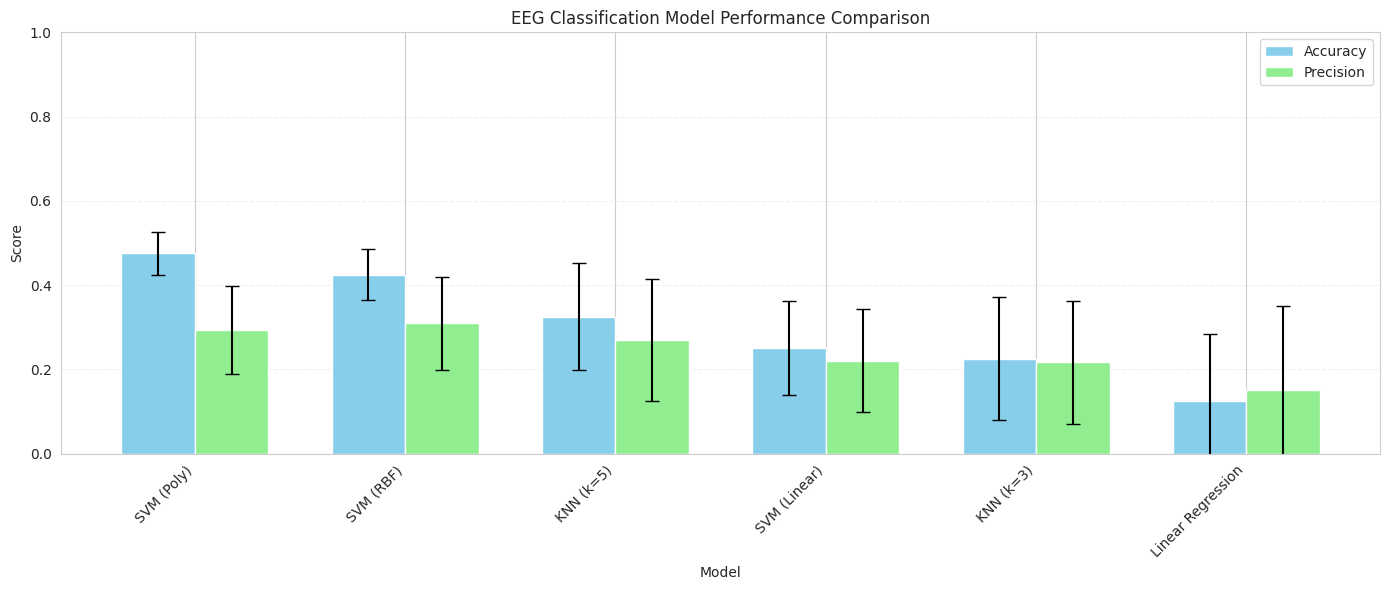


Best model: SVM (Poly)
Accuracy: 0.4750 ± 0.0500
Precision: 0.2929 ± 0.1045


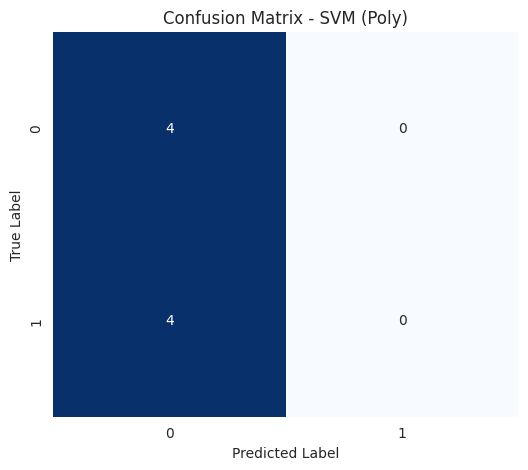


Classification complete!


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns

USE_PCA = True
N_COMPONENTS = 20
N_FOLDS = 5

print("Loading EEG data...")
df = pd.read_csv('/eeg data.csv')

X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

if USE_PCA:
    pca = PCA(n_components=N_COMPONENTS)
    X_processed = pca.fit_transform(X_scaled)
    print(f"Using PCA: Reduced from {X.shape[1]} to {X_processed.shape[1]} features")
    print(f"Explained variance: {sum(pca.explained_variance_ratio_)*100:.2f}%")
else:
    X_processed = X_scaled
    print(f"Using all {X.shape[1]} original features")

def evaluate_model_cv(model, X, y, model_name):
    """Evaluate model using stratified k-fold cross-validation"""
    start_time = time.time()

    cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

    cv_accuracy = []
    cv_precision = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        if isinstance(model, LinearRegression):
            y_pred = np.round(y_pred).astype(int)

        fold_accuracy = accuracy_score(y_test, y_pred)
        fold_precision = precision_score(y_test, y_pred, average='weighted')

        cv_accuracy.append(fold_accuracy)
        cv_precision.append(fold_precision)

    accuracy = np.mean(cv_accuracy)
    accuracy_std = np.std(cv_accuracy)
    precision = np.mean(cv_precision)
    precision_std = np.std(cv_precision)

    runtime = time.time() - start_time

    print(f"\n{model_name}:")
    print(f"  Accuracy: {accuracy:.4f} ± {accuracy_std:.4f}")
    print(f"  Precision: {precision:.4f} ± {precision_std:.4f}")
    print(f"  Runtime: {runtime:.4f} seconds")

    return {
        'model': model_name,
        'accuracy': accuracy,
        'accuracy_std': accuracy_std,
        'precision': precision,
        'precision_std': precision_std,
        'time': runtime
    }

models = {
    "Linear Regression": LinearRegression(),
    "SVM (Linear)": SVC(kernel='linear', random_state=42),
    "SVM (RBF)": SVC(kernel='rbf', random_state=42),
    "SVM (Poly)": SVC(kernel='poly', degree=3, random_state=42),
    "KNN (k=3)": KNeighborsClassifier(n_neighbors=3),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5)
}

results = []
print("\nTraining and evaluating models...")

for name, model in models.items():
    result = evaluate_model_cv(model, X_processed, y, name)
    results.append(result)

results_df = pd.DataFrame(results).sort_values(by='accuracy', ascending=False)
print("\nModel Performance Comparison:")
print(results_df[['model', 'accuracy', 'precision', 'time']])

plt.figure(figsize=(14, 6))
models = results_df['model']
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, results_df['accuracy'], width,
        yerr=results_df['accuracy_std'], label='Accuracy',
        color='skyblue', capsize=5)
plt.bar(x + width/2, results_df['precision'], width,
        yerr=results_df['precision_std'], label='Precision',
        color='lightgreen', capsize=5)

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('EEG Classification Model Performance Comparison')
plt.xticks(x, models, rotation=45, ha='right')
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

best_idx = results_df.index[0]
best_model_name = results_df.loc[best_idx, 'model']
print(f"\nBest model: {best_model_name}")
print(f"Accuracy: {results_df.loc[best_idx, 'accuracy']:.4f} ± {results_df.loc[best_idx, 'accuracy_std']:.4f}")
print(f"Precision: {results_df.loc[best_idx, 'precision']:.4f} ± {results_df.loc[best_idx, 'precision_std']:.4f}")

if "Linear Regression" in best_model_name:
    best_model = LinearRegression()
elif "SVM" in best_model_name:
    kernel = 'linear' if 'Linear' in best_model_name else 'rbf' if 'RBF' in best_model_name else 'poly'
    best_model = SVC(kernel=kernel, random_state=42)
else:
    k = 3 if 'k=3' in best_model_name else 5
    best_model = KNeighborsClassifier(n_neighbors=k)

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

for train_idx, test_idx in cv.split(X_processed, y):
    X_train, X_test = X_processed[train_idx], X_processed[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    if isinstance(best_model, LinearRegression):
        y_pred = np.round(y_pred).astype(int)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.show()
    break

print("\nClassification complete!")